In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as smf
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
df = pd.read_csv("wind_cleaned.csv")

I noticed an extraneous feature in the cleaned dataset that I need to remove:

In [ ]:
del df["Unnamed: 0"]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28200 entries, 0 to 28199
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   wind_speed(m/s)                 27927 non-null  float64
 1   atmospheric_temperature(°C)     24750 non-null  float64
 2   shaft_temperature(°C)           28198 non-null  float64
 3   blades_angle(°)                 27984 non-null  float64
 4   gearbox_temperature(°C)         28199 non-null  float64
 5   engine_temperature(°C)          28188 non-null  float64
 6   motor_torque(N-m)               28176 non-null  float64
 7   generator_temperature(°C)       28188 non-null  float64
 8   atmospheric_pressure(Pascal)    25493 non-null  float64
 9   area_temperature(°C)            28200 non-null  float64
 10  windmill_body_temperature(°C)   25837 non-null  float64
 11  wind_direction(°)               23097 non-null  float64
 12  resistance(ohm)                 

We want to split our data into independent(X) and dependent(y) data. Before we run a regression we have to fill the Nan's with a value. Here I am choosing to use the median value since there are so many missing values. Also due to the large differences in scales of my features I am standardizing my data so that the mean is 0 and the standard deviation is 1.

In [ ]:
df = (df-df.mean())/df.std()


X = df.iloc[:,:17]
y = df.iloc[:,17:18]
X = X.fillna(X.median())
y = y.fillna(y.median())

In [ ]:
X = smf.add_constant(X)
simple_model = smf.OLS(y, X).fit()
print(simple_model.summary())

                                  OLS Regression Results                                  
Dep. Variable:     windmill_generated_power(kW/h)   R-squared:                       0.410
Model:                                        OLS   Adj. R-squared:                  0.410
Method:                             Least Squares   F-statistic:                     1152.
Date:                            Fri, 01 Oct 2021   Prob (F-statistic):               0.00
Time:                                    20:52:59   Log-Likelihood:                -32471.
No. Observations:                           28200   AIC:                         6.498e+04
Df Residuals:                               28182   BIC:                         6.513e+04
Df Model:                                      17                                         
Covariance Type:                        nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025     

From this we can see that several features contribute strongly to the regression including windspeed, generator temperature, and engine temperature.Features with little impact on the regression include windmill body temperature, blade angle and atmospheric temperature. Previously I planned on removing wind speed from my calculations but after further analysis it appears the problem was just a matter of scale, therefore standardizing my dataset alleviated this problem.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


split_model = smf.OLS(y_train, X_train).fit()
predicted_ols_values = split_model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predicted_ols_values)
mse

0.5899508135782436

In [ ]:
rms = np.sqrt(mse)
rms

0.7680825564861135

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predicted_ols_values)
r2

0.4205215795436551

(-2.5451581095173825, 5.226991211286958)

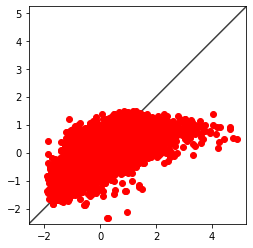

In [ ]:
# Code retrieved from https://stackoverflow.com/questions/25497402/adding-y-x-to-a-matplotlib-scatter-plot-if-i-havent-kept-track-of-all-the-data
# used to plot straight line

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(y_test, predicted_ols_values, 'ro')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)


We can see that the predicted values stray from the prediced values, though they both have a positive trend.

Because our dataset is quite large and posseses a large number of features I choose to use a lasso regression to make it more sparse.

In [ ]:
# Code taken from lecture week 5

from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from collections import defaultdict

alphas = [-1, -2, -5, -10, -25, 1, 2, 5, 10, 25]

lasso_results = defaultdict(dict)

for alph in alphas:
    modeling_pipeline_lasso = Pipeline([('lasso', Lasso(alpha=alph))])
    modeling_pipeline_lasso.fit(X_train, y_train)
    lasso_results['coefficients'][alph] = modeling_pipeline_lasso['lasso'].coef_
    lasso_results['training score'][alph] = modeling_pipeline_lasso.score(X_train, y_train)
    lasso_results['test score'][alph] = modeling_pipeline_lasso.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87684.3308449958, tolerance: 2.081800508590101
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425289.74681679904, tolerance: 2.081800508590101
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 825856.1742527485, tolerance: 2.081800508590101
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2027555.4565

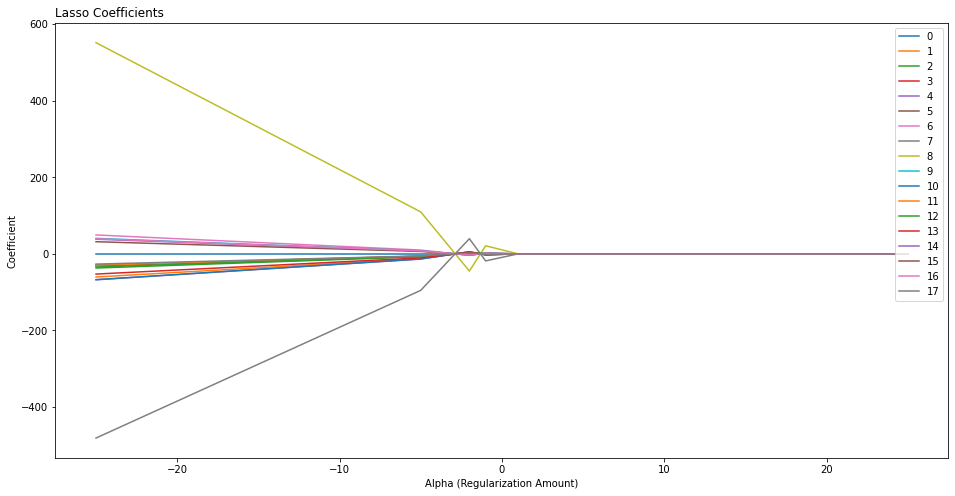

In [ ]:
coefficients = pd.DataFrame.from_dict(lasso_results['coefficients'])
coefficients = coefficients.reset_index()
coefficients = coefficients.rename(columns={'index':'coefficient_nbr'})
coefficients = coefficients.melt(id_vars='coefficient_nbr', var_name='alpha', value_name='coefficient')

coefficients.pivot_table(index='alpha', columns='coefficient_nbr', values='coefficient').plot(figsize=(16,8))
plt.title('Lasso Coefficients', loc='left')
plt.xlabel('Alpha (Regularization Amount)')
plt.ylabel('Coefficient')
plt.legend(loc='upper right')
plt.show()



I am not sure but I think the reason that only negative levels provide non-zero coefficients is that my model is underfit rather than overfit.